<a href="https://colab.research.google.com/github/calliopz/MachineLearning/blob/master/ML_Classifica%C3%A7%C3%A3o_texto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install livelossplot

In [0]:
#origem: https://github.com/tensorflow/workshops/blob/master/extras/keras-bag-of-words/keras-bow-model.ipynb
#importar bibliotecas

import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer


import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils, optimizers

from livelossplot.keras import PlotLossesCallback

from sklearn.metrics import classification_report

# This code was tested with TensorFlow v1.4
print("You have TensorFlow version", tf.__version__)

%matplotlib inline

Using TensorFlow backend.


You have TensorFlow version 1.13.1


In [0]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at drive


In [0]:
# faz leitura do CSV 


df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/LGG.csv', sep=';')
df = df[pd.notnull(df['tags'])]

df.head(10)

,tags,post
0,LGGCL01,3 exemplos de variações linguisticas
1,LGGCL01,5 neologismos
2,LGGCL01,a aprendizagem da norma culta da língua portug...
3,LGGCL01,a diferença entre linguagem formal e informal
4,LGGCL01,a importância da linguagem
5,LGGCL01,a importancia da linguagem escrita na
6,LGGCL01,a importancia da linguagem na formação do prof...
7,LGGCL01,a importancia da linguistica
8,LGGCL01,a importancia da linguistica textual no ensino...
9,LGGCL01,a importancia das variedades linguisticas


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18857 entries, 0 to 18856
Data columns (total 2 columns):
tags    18857 non-null object
post    18857 non-null object
dtypes: object(2)
memory usage: 442.0+ KB


In [0]:
# Calcula a quantidade de palavras na base de dados
print ('Quantidade de palavras totais:')
df['post'].astype(str).apply(lambda x: len(x.split(' '))).sum()

Quantidade de palavras totais:


105444

In [0]:
#descobre e cria uma lista de quais são as categorias possíveis na coluna 'tags'

my_tags = list(set(df['tags']))
print (my_tags)
print(len(my_tags))

['LGGCL03', 'LGGCL01', 'LGGCL08', 'LGGCL04', 'LGGCL05', 'LGGCL06', 'LGGCL02', 'LGGCL07']
8


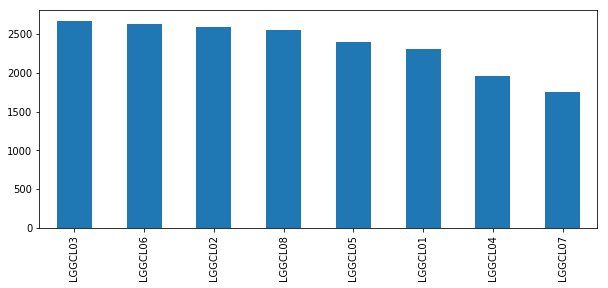

In [0]:
# Cria um gráfico comparando a distribuição das observações das tags

plt.figure(figsize=(10,4))
df.tags.value_counts().plot(kind='bar');


In [0]:
df.tags.value_counts()

LGGCL03    2673
LGGCL06    2633
LGGCL02    2590
LGGCL08    2553
LGGCL05    2395
LGGCL01    2307
LGGCL04    1959
LGGCL07    1747
Name: tags, dtype: int64

# Limpeza do texto

In [0]:
# Verificando como está o texto na coluna "post"
def print_plot(index):
    example = df[df.index == index][['post', 'tags']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])

print('Antes a limpeza:')

print_plot(10)

Antes a limpeza:
a lingua como pratica social
Tag: LGGCL01


In [0]:
# Limpeza do texto coluna "post"

import nltk
nltk.download('stopwords')

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('portuguese'))


def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    #text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

df['post'] = df['post'].astype(str).apply(clean_text)


print('Após a limpeza:')
print_plot(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Após a limpeza:
lingua pratica social
Tag: LGGCL01


In [0]:
print ('Quantidade de palavras após a limpeza:')

df['post'].apply(lambda x: len(x.split(' '))).sum()

Quantidade de palavras após a limpeza:


74648

# Início do Machine Learning

In [0]:
print ('Quantidade de observações a serem trabalhadas:')
len(df)

Quantidade de observações a serem trabalhadas:


18857

In [0]:
#Embaralhar DF
from sklearn.utils import shuffle
df = shuffle(df)

In [0]:
train_size = int(len(df) * .7)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(df) - train_size))

Train size: 13199
Test size: 5658


In [0]:
train_posts = df['post'][:train_size]
train_tags = df['tags'][:train_size]

test_posts = df['post'][train_size:]
test_tags = df['tags'][train_size:]

In [0]:
max_words = 100
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [0]:
tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

In [0]:
encoder = LabelEncoder()
encoder.fit(my_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [0]:
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [0]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (13199, 100)
x_test shape: (5658, 100)
y_train shape: (13199, 8)
y_test shape: (5658, 8)


# Deep Learning

In [0]:
# Parâmetros do treino
batch_size = 100
epochs = 25

In [0]:
# Modelo 1
# Build the model


model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(max_words,)))
model.add(Dropout(0.75))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
#model.add(Dense(16, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense((num_classes), activation='softmax'))

sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.5, nesterov=True)
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

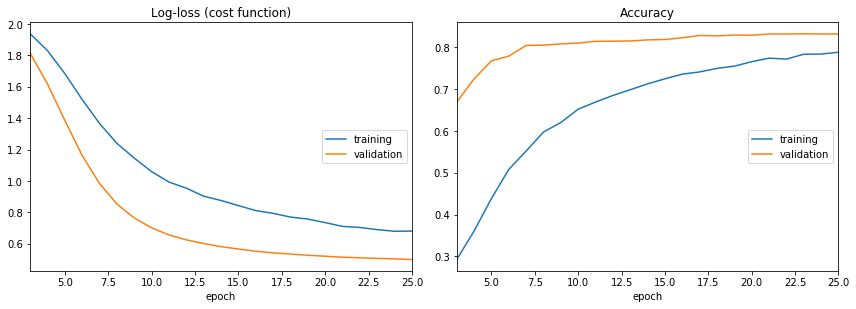

Log-loss (cost function):
training   (min:    0.679, max:    2.066, cur:    0.680)
validation (min:    0.499, max:    2.022, cur:    0.499)

Accuracy:
training   (min:    0.170, max:    0.789, cur:    0.789)
validation (min:    0.462, max:    0.833, cur:    0.832)
5658/5658 [==============================] - 0s 22us/step
Test accuracy: 0.8375751124586306


In [0]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[PlotLossesCallback()],
                    verbose=1,
                    shuffle=True,
                    validation_split=0.15)

score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

# Métodos Alternativos

> Indented block




In [0]:
X = df.post
y = df.tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

# Naive Bayes Classifier for Multinomial Models

In [0]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

%time

y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))



CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.11 µs
accuracy 0.9383174266525274
              precision    recall  f1-score   support

     LGGCL03       0.93      0.87      0.90       690
     LGGCL05       0.96      0.92      0.94       739
     LGGCL04       0.85      0.97      0.90       794
     LGGCL07       0.91      0.82      0.86       606
     LGGCL02       0.93      0.97      0.95       688
     LGGCL01       0.99      0.96      0.98       831
     LGGCL08       0.99      0.99      0.99       538
     LGGCL06       0.97      0.99      0.98       772

    accuracy                           0.94      5658
   macro avg       0.94      0.94      0.94      5658
weighted avg       0.94      0.94      0.94      5658



# Linear Support Vector Machine

In [0]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

%time

y_pred = sgd.predict(X_test)

my_tags = list(set(y_train))

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.63 µs
accuracy 0.9377872039589961
              precision    recall  f1-score   support

     LGGCL03       0.95      0.85      0.90       681
     LGGCL01       0.98      0.92      0.95       784
     LGGCL08       0.85      0.97      0.90       804
     LGGCL04       0.87      0.85      0.86       587
     LGGCL05       0.92      0.97      0.94       723
     LGGCL06       0.99      0.96      0.97       815
     LGGCL02       0.99      0.99      0.99       515
     LGGCL07       0.97      0.99      0.98       749

    accuracy                           0.94      5658
   macro avg       0.94      0.94      0.94      5658
weighted avg       0.94      0.94      0.94      5658



In [0]:
text_labels = encoder.classes_ 

for i in range(10):
    prediction = sgd.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_posts.iloc[i][:50], "...")
    print('Actual label:' + test_tags.iloc[i])
    print("Predicted label: " + predicted_label + "\n")

# Salvar modelo em arquivo JSON

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Modelo salvo em arquivo")

Modelo salvo em arquivo


# Carregar modelo do Arquivo

In [0]:
from keras.models import model_from_json

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Modelo carregado do arquivo")

Modelo carregado do arquivo


In [0]:
# Testar modelo carregado 

loaded_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
score = loaded_model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

# Apêndice

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


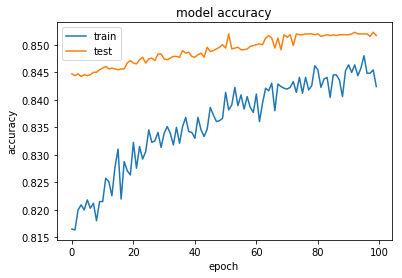

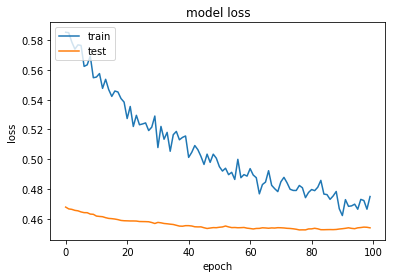

In [0]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Here's how to generate a prediction on individual examples
text_labels = encoder.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_posts.iloc[i][:50], "...")
    print('Actual label:' + test_tags.iloc[i])
    print("Predicted label: " + predicted_label + "\n")

palavra licença ...
Actual label:LGGCL04
Predicted label: LGGCL03

lei universal direitos humanos ...
Actual label:LGGCL06
Predicted label: LGGCL06

museu ciencia ...
Actual label:LGGCL02
Predicted label: LGGCL02

dominar norma culta língua portuguesa ...
Actual label:LGGCL01
Predicted label: LGGCL01

funçao poetica ...
Actual label:LGGCL04
Predicted label: LGGCL03

textos românticos pequenos ...
Actual label:LGGCL05
Predicted label: LGGCL05

ditadura militar trabalho pronto ...
Actual label:LGGCL06
Predicted label: LGGCL06

prova tecnologia informação comunicação ...
Actual label:LGGCL08
Predicted label: LGGCL08

lauren zalaznik: consciência televisão executiva t ...
Actual label:LGGCL04
Predicted label: LGGCL02

generos musicais funk ...
Actual label:LGGCL02
Predicted label: LGGCL02



In [0]:
y_softmax = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)
    
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)
    
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()